# Download dataset

In [1]:
!mkdir /content/dataset

In [2]:
%cp /content/drive/MyDrive/Colab/pydomains/screenshots/processed/processed_v2.tar /content/dataset/

In [3]:
%cd /content/dataset

/content/dataset


In [16]:
!tar xf processed_v2.tar

In [17]:
!ls -ltr

total 5552816
drwxr-xr-x 41 root root       4096 Apr 27 20:48 processed
-rw-------  1 root root 5686072318 Apr 28 00:09 processed_v2.tar


In [18]:
!find processed -type f | wc -l

227467


# Resource Details

In [19]:
!nvidia-smi

Fri Apr 28 00:12:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
!cat /proc/cpuinfo | grep ^processor

processor	: 0
processor	: 1
processor	: 2
processor	: 3
processor	: 4
processor	: 5
processor	: 6
processor	: 7
processor	: 8
processor	: 9
processor	: 10
processor	: 11


In [21]:
!cat /proc/meminfo | grep ^MemTotal

MemTotal:       87538728 kB


GPU - A100 <br>
CPU - 12 cores <br>
RAM - 88 GB <br>

# View samples in data

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import tensorflow as tf
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [23]:
data_dir = pathlib.Path("/content/dataset/processed")

In [24]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

207849


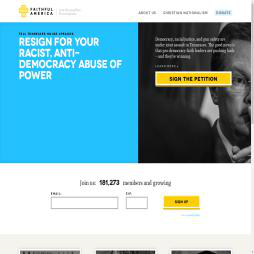

In [25]:
education = list(data_dir.glob('education/*'))
PIL.Image.open(str(education[0]))

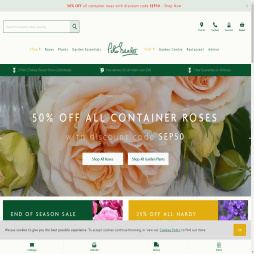

In [26]:
shopping = list(data_dir.glob('shopping/*'))
PIL.Image.open(str(shopping[0]))

# Split dataset

In [63]:
batch_size = 32
img_height = 254 
img_width = 254

In [64]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 227467 files belonging to 39 classes.
Using 181974 files for training.


In [65]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 227467 files belonging to 39 classes.
Using 45493 files for validation.


In [66]:
class_names = train_ds.class_names
print(class_names)

['adv', 'alcohol', 'automobile', 'dating', 'downloads', 'drugs', 'education', 'finance', 'fortunetelling', 'forum', 'gamble', 'government', 'hobby', 'hospitals', 'imagehosting', 'isp', 'jobsearch', 'models', 'movies', 'music', 'news', 'politics', 'porn', 'radiotv', 'recreation', 'redirector', 'religion', 'science', 'searchengines', 'sex', 'shopping', 'socialnet', 'spyware', 'tracker', 'urlshortener', 'warez', 'weapons', 'webmail', 'webradio']


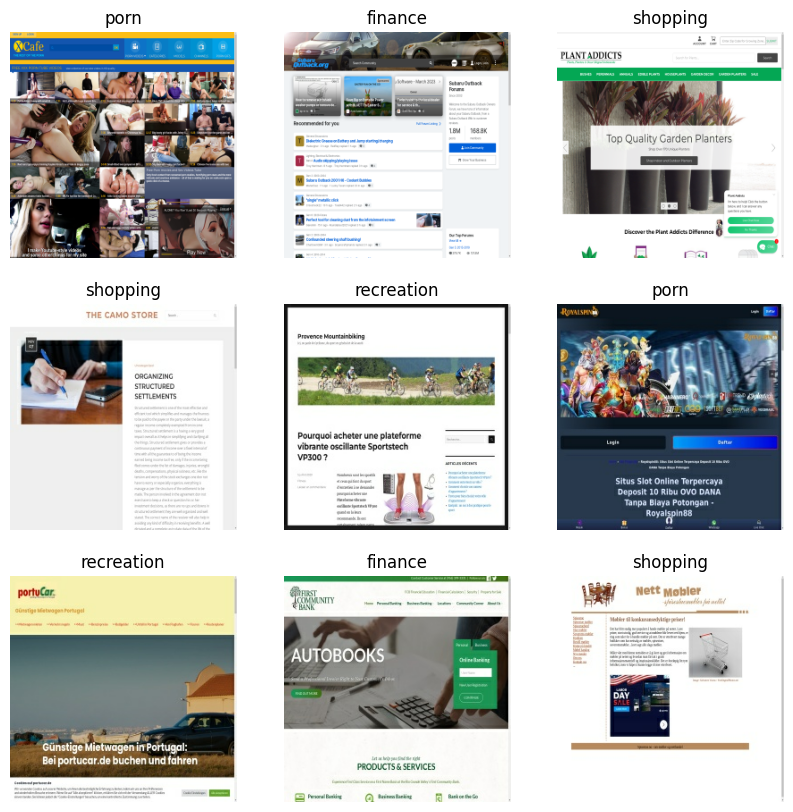

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [68]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 254, 254, 3)
(32,)


In [69]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [70]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 1138
Number of test batches: 284


In [71]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Tranfer learning using MobilenetV3
With input size 254x254 

In [106]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [107]:
IMG_SIZE = (img_width, img_height)
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
)


94765736/94765736 [==============================] - 0s 0us/step


In [108]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 2048)


In [109]:
base_model.trainable = False

In [110]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [111]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [112]:
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 39)


In [113]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [114]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [115]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 254, 254, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 254, 254, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 254, 254, 3)      0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0   

In [117]:
len(model.trainable_variables)


2

# Evaluate on validation set before training

In [118]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

1138/1138 [==============================] - 31s 25ms/step - loss: 4.2642 - accuracy: 0.0142


In [119]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.26
initial accuracy: 0.01


# Train model

In [120]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
5687/5687 [==============================] - 176s 30ms/step - loss: 1.8405 - accuracy: 0.4515 - val_loss: 1.6759 - val_accuracy: 0.5035
Epoch 2/10
5687/5687 [==============================] - 172s 30ms/step - loss: 1.6769 - accuracy: 0.4983 - val_loss: 1.6383 - val_accuracy: 0.5144
Epoch 3/10
5687/5687 [==============================] - 172s 30ms/step - loss: 1.6355 - accuracy: 0.5074 - val_loss: 1.6175 - val_accuracy: 0.5215
Epoch 4/10
5687/5687 [==============================] - 172s 30ms/step - loss: 1.6131 - accuracy: 0.5134 - val_loss: 1.6091 - val_accuracy: 0.5212
Epoch 5/10
5687/5687 [==============================] - 172s 30ms/step - loss: 1.5967 - accuracy: 0.5161 - val_loss: 1.6061 - val_accuracy: 0.5215
Epoch 6/10
5687/5687 [==============================] - 172s 30ms/step - loss: 1.5874 - accuracy: 0.5171 - val_loss: 1.5982 - val_accuracy: 0.5241
Epoch 7/10
5687/5687 [==============================] - 172s 30ms/step - loss: 1.5793 - accuracy: 0.5189 - val_loss: 1

# Plot accuracy

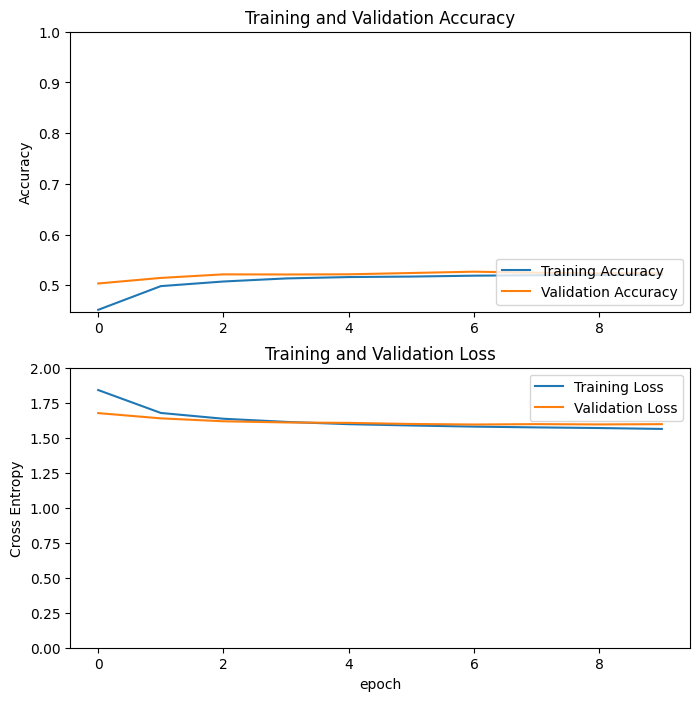

In [121]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate model on validation set after training

In [122]:
loss0, accuracy0 = model.evaluate(val_ds)

1138/1138 [==============================] - 29s 24ms/step - loss: 1.5951 - accuracy: 0.5237


# Evaluate model on test set 

In [123]:
loss0, accuracy0 = model.evaluate(test_dataset)

284/284 [==============================] - 7s 24ms/step - loss: 1.5868 - accuracy: 0.5285


In [124]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)


In [125]:
image_batch.shape

(32, 254, 254, 3)

In [126]:
label_batch.shape

(32,)

In [127]:
predictions.shape

(32, 39)

In [128]:
tf.nn.softmax(predictions)

<tf.Tensor: shape=(32, 39), dtype=float32, numpy=
array([[1.1691437e-03, 3.4984882e-04, 1.8209864e-03, ..., 2.3035619e-04,
        1.1014268e-04, 3.3930850e-03],
       [2.5974419e-03, 5.1804473e-05, 4.4312179e-03, ..., 8.9034016e-05,
        1.8883830e-04, 1.1609711e-03],
       [1.5299727e-03, 4.9333164e-04, 2.2791005e-03, ..., 9.8261466e-05,
        5.2461721e-04, 1.2753757e-02],
       ...,
       [4.3324074e-03, 1.5755167e-04, 8.1036957e-03, ..., 1.9930916e-04,
        3.0318354e-04, 6.6324933e-03],
       [1.7775111e-04, 1.6802002e-03, 7.4847467e-04, ..., 1.5227677e-05,
        1.0612358e-05, 1.2499645e-05],
       [8.5295634e-03, 2.0236704e-03, 9.2792530e-03, ..., 8.5688746e-03,
        6.6013646e-04, 4.6307282e-03]], dtype=float32)>

In [129]:
preds = tf.math.argmax(tf.nn.softmax(predictions), axis=1)

In [130]:
preds.numpy()

array([30, 24, 24,  9, 30, 24, 22,  7, 24,  7,  7, 12, 24, 24,  7, 22, 24,
       22, 30, 22, 22, 24, 24, 24, 24, 22, 30, 22, 30, 22, 30, 30])

In [131]:
label_batch

array([ 7,  6, 24, 24, 20, 24, 24,  7, 24,  7,  7, 12,  6, 30,  7, 22, 24,
       22, 24, 22, 22, 24, 24,  7, 12, 22, 24, 22, 12, 19,  7, 30],
      dtype=int32)

In [132]:
preds[0].numpy()

30

# Display predictions

In [133]:
plt.figure(figsize=(25, 25))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"{class_names[label_batch[i]]} - pred:{class_names[preds[i].numpy()]}")
  plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

# Save Model

In [134]:
!pwd

/content/dataset


In [135]:
!mkdir -p saved_model
model.save('saved_model/pydomains_images')

In [136]:
!ls -ltr

total 5570080
drwxr-xr-x 41 root root       4096 Apr 27 20:48 processed
-rw-------  1 root root 5686072318 Apr 28 00:09 processed_v2.tar
drwxr-xr-x  3 root root       4096 Apr 28 01:19 saved_model
-rw-r--r--  1 root root   17674240 Apr 28 01:19 saved_model.tar


In [137]:
!tar cf saved_model_resnet.tar saved_model/

In [138]:
!cp saved_model_resnet.tar /content/drive/MyDrive/Colab/pydomains/screenshots/processed/

In [139]:
!du -sh saved_model_resnet.tar

96M	saved_model_resnet.tar
